In [1]:
import scvi
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import gc
import sys
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from latentmi import lmi
from data_utils import *
import seaborn as sns
import matplotlib.pyplot as plt

from nanoTxformer.model import nanoTxformer
from nanoTxformer.train import train_model, generalization_loss
from nanoTxformer.utils import get_mean_pooled_embeddings

torch.set_float32_matmul_precision('medium')

Global seed set to 0
/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
d = {
    "Quality" : [],
    "UMI per cell" : [],
    "MI" : [],
    "N cells" : [],
    "Val. loss" : [],
    "Losses" : [],
}

dataset_fractions = 5*np.logspace(-5, -3, 5)*4

In [3]:
qual = 1.
r = 0

ad = sc.read_h5ad('../../scaling_playground/data/PBMC_CITEseq_Q%.3f_rep%d.h5ad'
                  %(qual, r))

UMI_per_cell = ad.raw.X.sum()/len(ad)

seen, held_out = split_ad(ad, frac=0.75)

In [4]:
d_c = {
    "MI" : [],
    "Val. loss" : [],
    "Epochs" : [],
}

ad1, ad2 = split_ad(seen, frac=0.01)

model = nanoTxformer(ad1, embed_size=512, 
                    num_heads=8, num_encoder_layers=2).cuda()

for i in range(5):

    ##############
    ### nanoTx ###
    ##############

    val_loss = generalization_loss(model, held_out)
    batch_size = 32
    losses = train_model(model, ad1, epochs=1, batch_size=batch_size, 
                         val_per_batch=10**7)
    emb = get_mean_pooled_embeddings(model, held_out).cpu()
    pmis, _, _ = lmi.estimate(emb, held_out.obsm['protein_counts'], 
                        quiet=True, batch_size=2048)
    

    d_c['MI'].append(np.nanmean(pmis))
    d_c['Val. loss'].append(val_loss)
    d_c['Epochs'].append(i)

    print(d_c)

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻{'MI': [3.3295910366116854], 'Val. loss': [7.750621773796334], 'Epochs': [0]}
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻{'MI': [3.3295910366116854, 3.3614843230469833], 'Val. loss': [7.750621773796334, 1.452336543349088], 'Epochs': [0, 1]}
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻{'MI': [3.3295910366116854, 3.3614843230469833, 3.258191244905013], 'Val. loss': [7.750621773796334, 1.452336543349088, 1.2370481381034872], 'Epochs': [0, 1, 2]}
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻{'MI': [3.3295910366116854, 3.3614843230469833, 3.258191244905013, 3.2069430481724583], 'Val. loss': [7.750621773796334, 1.452336543349088, 1.2370481381034872, 1.196946912918921], 'Epochs': [0, 1, 2, 3]}
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻{'MI': [3.3295910366116854, 3.3614843230469833, 3.258191244905013, 3.2069430481724583, 3.2968050044651314], 'Val. loss': [7.750621773796334, 1.452336543349088, 1.2370481381034872, 1.196946912918921, 1.1830431517639173], 'Epochs': [0, 1, 2, 3, 4]}


(0.0, 3.5)

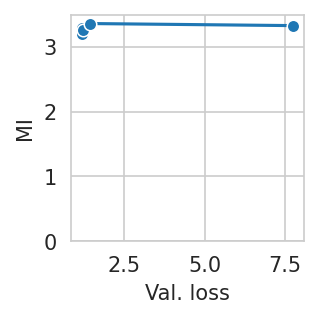

In [11]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (2,2)
df_c = pd.DataFrame(d_c)

sns.set_style('whitegrid')
sns.lineplot(data=df_c, x='Val. loss', y='MI', marker='o') 
                # hue='Epochs')
plt.ylim(0, 3.5)
# plt.xscale('log')